# Nonlinear ODE using a parallel-in-time method

Now that we are familiar with the nonlinear ODE, we will solve it using the parallel-in-time method ParaDiag.
First, we rewrite the ODE to place all terms on the left hand side:

$$
\partial_{t}q - f(q) = \partial_{t}q - (\lambda q + wq^{2}) = 0
$$

The implicit theta method discretisation then looks like:

$$
\frac{q^{n+1}-q^{n}}{\Delta t} - (\theta f(q^{n+1}) + (1-\theta)f(q^{n})) = 0
$$

We can now construct the all-at-once system which couples all timesteps in the time-series together into a single problem. For 4 timesteps this looks like:

$$
\frac{1}{\Delta t}
\begin{pmatrix}
 1 &  0 &  0 & 0 \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\begin{pmatrix}
q^{1} \\ q^{2} \\ q^{3} \\ q^{4} \\
\end{pmatrix}
-
\begin{pmatrix}
\theta     & 0          & 0          & 0 \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\begin{pmatrix}
f(q^{1}) \\ f(q^{2}) \\ f(q^{3}) \\ f(q^{4}) \\
\end{pmatrix}
=
\textbf{b}
$$

The left hand side can be written using the two Toeplitz matrices $\textbf{B}_{1}$ and $\textbf{B}_{2}$ which define the implicit theta method:

$$
\frac{1}{\Delta t}\textbf{B}_{1}\textbf{q} + \textbf{B}_{2}\textbf{f}(\textbf{q})
$$

Where $\textbf{q}$ is the vector of the timeseries $q^{n}$.

The right hand side vector $\textbf{b}$ contains the initial condition:

$$
\begin{pmatrix}
q^{0}/\Delta t + (1-\theta)\lambda q^{0} \\ 0 \\ 0 \\ 0
\end{pmatrix}
$$

## Implementing the all-at-once system

We start as for the serial method by defining the problem parameters. This time we will need a vector for the time at each timestep.

In [2]:
import numpy as np

T = 102.4
nt = 1024
dt = T/nt
theta = 0.5
lamda = -0.02 + 0.3j
w = -0.25
q0 = 1

time = np.linspace(dt, nt*dt, num=nt, endpoint=True)

We define the function $f(q)$ and it's Jacobian:

In [3]:
def f(q):
    return lamda*q + w*q*q

def df(q):
    return lamda + 2*w*q

The initial condition on the right hand side is:

In [86]:
rhs = np.zeros(nt, dtype=complex)
rhs[0] += (1/dt + (1-theta)*lamda)*q0

Now we can move on to matrices on the left hand side. Toeplitz matrices can be represented using two vectors, one for the first column and one for the first row. For the lower triangular timestepping matrices $\textbf{B}_{1,2}$ these are:

In [4]:
b1col = np.zeros(nt, dtype=complex)
b1col[0] = 1
b1col[1] = -1

b1row = np.zeros_like(b1col)
b1row[0] = b1col[0]

b2col = np.zeros(nt, dtype=complex)
b2col[0] = theta
b2col[1] = 1-theta

b2row = np.zeros_like(b2col)
b2row[0] = b2col[0]

B1 = tuple((b1col, b1row))
B2 = tuple((b2col, b2row))

Now we define the residual function for the all-at-once system:

$$
\textbf{F}(\textbf{q}) =
\frac{1}{\Delta t}\textbf{B}_{1}\textbf{q}
+ \textbf{B}_{2}\textbf{f}(\textbf{q})
- \textbf{b}
= 0
$$

Implement this below. _Remember you can use linalg.matmul_toeplitz with the matrices `B1` and `B2`_

In [5]:
from scipy import linalg

def residual(q):
    B1q = linalg.matmul_toeplitz(B1, q)
    B2f = linalg.matmul_toeplitz(B2, f(q))                                 
    return B1q + B2f - rhs 

The `dtype` and `shape` members are a required part of the `LinearOperator` interface.
Now we can define the all-at-once Jacobian:

In [7]:
import scipy.sparse.linalg as spla
from scipy.fft import fft, ifft

class AveragedCirculantLinearOperator(spla.LinearOperator):
    def __init__(self, b1, b2):
        self.dtype = b1.dtype
        n = len(b1)
        self.shape = tuple((n, n))

        self.b1 = b1
        self.b2 = b2

        self.l1 = fft(b1, norm='backward')
        self.l2 = fft(b2, norm='backward')

        self.qav = 0

    def _matvec(self, v):
        diag = self.l1 + self.l2*df(self.qav)
        return ifft(fft(v)/diag)

    def update(self, q, f):
        self.qav = np.sum(q)/len(q)

As a first attempt at solving the all-at-once system we will blindly use [GMRES](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.gmres.html) with no preconditioner. Because we have defined the Jacobian as a `LinearOperator` we can use SciPy's GMRES implementation. At each iteration we will print out the iteration number and the residual `pr_norm`.

In [93]:
niterations=0
def gmres_callback(pr_norm):
    global niterations
    niterations+=1
    print(f"niterations: {str(niterations).rjust(5,' ')} | residual: {pr_norm}")
    return

y, exit_code = spla.gmres(A, rhs,
                          callback=gmres_callback,
                          callback_type='pr_norm')

niterations:     1 | residual: 0.919236839650919
niterations:     2 | residual: 0.8767725218151128
niterations:     3 | residual: 0.834891293149787
niterations:     4 | residual: 0.7870038960370259
niterations:     5 | residual: 0.7342591939839072
niterations:     6 | residual: 0.6803379085630151
niterations:     7 | residual: 0.628815951991392
niterations:     8 | residual: 0.5820296523433299
niterations:     9 | residual: 0.5409933403703501
niterations:    10 | residual: 0.5057712823031488
niterations:    11 | residual: 0.475893897017508
niterations:    12 | residual: 0.45066260616616255
niterations:    13 | residual: 0.42933149041566027
niterations:    14 | residual: 0.41119981931197985
niterations:    15 | residual: 0.3956508853714548
niterations:    16 | residual: 0.38216211534424743
niterations:    17 | residual: 0.37030143568371626
niterations:    18 | residual: 0.35971801833030315
niterations:    19 | residual: 0.3501314443713473
niterations:    20 | residual: 0.341321084525310

niterations:   542 | residual: 0.06364984326454237
niterations:   543 | residual: 0.0635601352708598
niterations:   544 | residual: 0.06347284177144838
niterations:   545 | residual: 0.06338595561582994
niterations:   546 | residual: 0.06330053729729102
niterations:   547 | residual: 0.0632147323161821
niterations:   548 | residual: 0.06312874781395196
niterations:   549 | residual: 0.0630423679001872
niterations:   550 | residual: 0.06295523628436046
niterations:   551 | residual: 0.06286759292533355
niterations:   552 | residual: 0.06277955446217043
niterations:   553 | residual: 0.0626914322623724
niterations:   554 | residual: 0.06260344837504751
niterations:   555 | residual: 0.062516541946224
niterations:   556 | residual: 0.06243033925931943
niterations:   557 | residual: 0.06234673164213866
niterations:   558 | residual: 0.06226485126681868
niterations:   559 | residual: 0.06218422259251711
niterations:   560 | residual: 0.06210501580011964
niterations:   561 | residual: 0.0620

niterations:  1100 | residual: 0.021288646581987553
niterations:  1101 | residual: 0.02125873520235564
niterations:  1102 | residual: 0.021228240941059424
niterations:  1103 | residual: 0.021197977396820993
niterations:  1104 | residual: 0.02116785823361289
niterations:  1105 | residual: 0.021137686732138217
niterations:  1106 | residual: 0.021107570206751254
niterations:  1107 | residual: 0.021077273804803356
niterations:  1108 | residual: 0.02104684508279726
niterations:  1109 | residual: 0.021016253658441515
niterations:  1110 | residual: 0.02098547886611528
niterations:  1111 | residual: 0.020954565390836684
niterations:  1112 | residual: 0.020923525311797937
niterations:  1113 | residual: 0.020892426590959166
niterations:  1114 | residual: 0.02086128954775417
niterations:  1115 | residual: 0.02083020275273184
niterations:  1116 | residual: 0.020799181860004002
niterations:  1117 | residual: 0.020768332528128163
niterations:  1118 | residual: 0.020737650482067556
niterations:  1119

In [94]:
print(f"gmres exit code: {exit_code}")
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(y))}")

gmres exit code: 0
gmres iterations: 1633
residual: 0.000373498777178137


Clearly this is an incredibly inefficient solution strategy! In the rest of this notebook we will create an effective preconditioner for the all-at-once Jacobian using diagonalisation.

_You may have noticed that it took more than $N_{t}$ iterations for GMRES to converge, even though this method should converge in at most $n$ iterations for an $n\times n$ matrix. This is because SciPy uses a restarted GMRES method with a restart of 20 iterations by default. You can change this using the `restart` kwarg. The `tol` and `atol` kwargs can also be used to control the solver tolerance._

The first preconditioner will be a circulant matrix, which are often good preconditioners for Toeplitz matrices (especially triangular Toeplitz matrices). The circulated version of the all-at-once matrix is:

$$
\begin{pmatrix}
 1 &  0 &  0 & -1 \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\frac{1}{\Delta t}
-
\begin{pmatrix}
\theta     & 0          & 0          & (1-\theta) \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\lambda
=
\textbf{C}_{1}\frac{1}{\Delta t} - \textbf{C}_{2}\lambda
$$

Which is the all-at-once Jacobian obtained for a time-periodic problem with period `T`. All circulant matrices are simultaneously diagonalisable using the discrete fourier transform (DFT) matrix:

$$
\textbf{C} = \textbf{V}\textbf{D}\textbf{V}^{-1},
\quad\quad
\textbf{D} = \textbf{V}^{-1}\textbf{C}[:,0]
$$

Where $\textbf{V}^{-1}=\textbf{F}$ is the DFT matrix, and $\textbf{D}$ is the (diagonal) matrix of eigenvalues which are calculated as the Fourier transform of the first column of $\textbf{C}$.
The inverse of a circulant matrix can be efficiently calculated in three steps:
1. Multiplying by the inverse eigenvector matrix (i.e. an FFT)
2. Dividing by the eigenvalue matrix
3. Multiplying by the eigenvector matrix (i.e. an IFFT)

We are now ready to implement our circulant preconditioner. SciPy's GMRES routine will take a `LinearOperator` to use as a preconditioner, so this is what we will create. Finish the class skeleton below by completing the `__init__` method and filling out the `_matvec` method using the steps listed above.

In [95]:
from scipy.fft import fft, ifft

class CirculantLinearOperator(spla.LinearOperator):
    def __init__(self, col):
        self.dtype = col.dtype
        self.shape = tuple((len(col), len(col)))
        # delete below here
        self.col = col
        self.eigvals = fft(col, norm='backward')

    def _matvec(self, v):
        # delete below here
        return ifft(fft(v)/self.eigvals)

Now time to test out our new preconditioner by trying to solve the all-at-once system again:

In [97]:
P = CirculantLinearOperator(acol)

niterations=0

y, exit_code = spla.gmres(A, rhs, M=P,
                          callback=gmres_callback,
                          callback_type='pr_norm')

print(f"gmres exit code: {exit_code}")
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(y))}")

niterations:     1 | residual: 0.6494798811776651
niterations:     2 | residual: 2.0292865247959054e-14
gmres exit code: 0
gmres iterations: 2
residual: 7.555034205419826e-13


What an improvement! The system is now solved almost to machine precision after two iterations. Clearly the circulant matrix is a very effective preconditioner for the all-at-once system of the Dalhquist equation. However, notice that the residual is not particularly small at the first iteration, then plummets at the second. Can we do better?

_Trying to do better than two iterations might seem unnecessary, but once we move on to solving PDEs the iteration counts will not be as low, and a better preconditioner will have a larger effect._ 

_It is possible to show that GMRES for the all-at-once system of a linear scalar ODE preconditioned by the circulant matrix will converge in at most two iterations. Why is this?_

Before trying the next preconditioner, we should check that the solution looks as we expect.

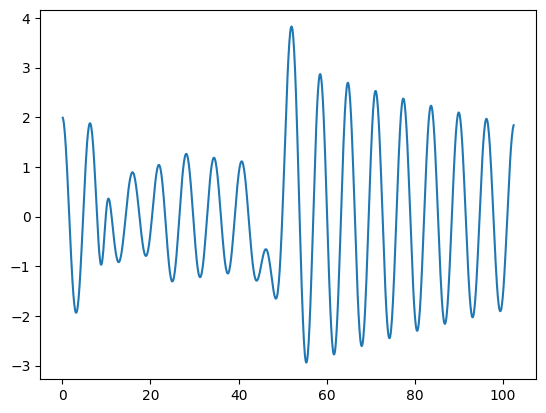

In [100]:
import matplotlib.pyplot as plt

plt.plot(time, y.real)
plt.show()

$\alpha$-circulant matrices are very similar to circulant matrices, except that the circulant entries are scaled by a small parameter $\alpha\in(0,1]$. For our all-at-once system this will look like:

$$
\begin{pmatrix}
 1 &  0 &  0 & -\alpha \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\frac{1}{\Delta t}
-
\begin{pmatrix}
\theta     & 0          & 0          & \alpha(1-\theta) \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\lambda
=
\textbf{C}^{(\alpha)}_{1}\frac{1}{\Delta t} - \textbf{C}^{(\alpha)}_{2}\lambda
$$

Clearly the standard circulant matrix is recovered when $\alpha=1$. Fortunately for us, just like the standard circulant matrices all $\alpha$-circulant matrices with the same $\alpha$ can be simultaneously diagonalised. The eigendecomposition is still known analytically but is slightly more complicated:

$$
\textbf{C}^{(\alpha)} = \textbf{V}\textbf{D}\textbf{V}^{-1}
$$
where:
$$
\textbf{V}^{-1} = \textbf{F}\Gamma_{\alpha},
\quad
\textbf{D} = \textbf{F}\Gamma_{\alpha}\textbf{C}[:,0]
$$
and $\Gamma_{\alpha}$ is the diagonal matrix:
$$
\Gamma_{\alpha} = \text{diag}\left(\alpha^{\frac{k-1}{N_{t}}}\right)\; \forall k \in [1, N_{t}]
$$

To use this matrix as a preconditioner we will again create a `LinearOperator`. Complete the class skeleton below by finishing the `__init__` method and implementing the `_matvec` method.

In [101]:
class AlphaCirculantLinearOperator(spla.LinearOperator):
    def __init__(self, col, alpha=1):
        self.dtype = col.dtype
        n = len(col)
        self.shape = tuple((n, n))
        # delete below here
        self.alpha = alpha
        self.col = col         

        # fft weighting
        self.gamma = alpha**(np.arange(n)/n)

        # eigenvalues
        self.eigvals = fft(col*self.gamma, norm='backward')

    def _to_eigvecs(self, v): 
        return fft(v*self.gamma, norm='ortho')

    def _from_eigvecs(self, v): 
        return ifft(v, norm='ortho')/self.gamma                            

    def _matvec(self, v): 
        return self._from_eigvecs(self._to_eigvecs(v)/self.eigvals)

Now we can try out our new preconditioner. We can pick some small value of `\alpha` and see how the preconditioner performs.

In [111]:
alpha = 0.1

Pa = AlphaCirculantLinearOperator(acol, alpha)

niterations=0

y, exit_code = spla.gmres(A, rhs, M=Pa,
                          callback=gmres_callback,
                          callback_type='pr_norm')

print(f"gmres exit code: {exit_code}")
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(y))}")

niterations:     1 | residual: 0.09128799670404905
niterations:     2 | residual: 3.965089875611609e-15
gmres exit code: 0
gmres iterations: 2
residual: 5.402953386192433e-13


The solver again converges in two iterations, as expected for the case of a linear scalar ODE, but this time the residual at the first iteration is much smaller. Try different values of $\alpha$ and see how this affects the residuals. You might have to reduce the `tol` and `atol` to make sure two iterations are still carried out.
Some other questions you could look into are:
- What does a plot of the residual after one iteration vs $\alpha$ look like?
- What happens when $\alpha$ approaches machine zero?
- What happens if you change the problem parameters, e.g. `nt`, `dt`, `lamda`?

_You should check your implementation of the $\alpha$-circulant operator by setting `alpha=1` and verifying that you get the same residuals as with the standard circulant operator above. This doesn't rule out all mistakes but is still good to do._